# Import Libraries

In [1]:
import os # for file management
import glob # for file management and can search for files using patterns
import random # for random number generation
import shutil # for file management for example moving
import tensorflow as tf # for machine learning
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm # for progress bar - can be run in multi-threaded mode

2024-02-15 14:45:12.454444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 14:45:12.454623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 14:45:12.545844: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 14:45:12.685082: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 14:45:13.610056: W tensorflow/compiler/tf2

# Download Data

H.P. Lovecraft was an American writer of weird fiction and horror fiction. He is best known for his creation of what became the Cthulhu Mythos. His work was virtually unknown during his lifetime and published only in pulp magazines before he died in poverty, but he is now regarded as one of the most significant 20th-century authors of horror and weird fiction.

https://github.com/vilmibm/lovecraftcorpus

In [2]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

# Just use 20 files.
file_number = 20 # there are more than 20 files in the repo, but we start with 20

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path) # creates paths

    # Clone the repo.
    !git clone https://github.com/vilmibm/lovecraftcorpus
        
    # Find all the files.
    paths_all = glob.glob("lovecraftcorpus/*.txt")
    print(sorted(paths_all))

    # Standardize.
    for path in paths_all:
        content = open(path).read()
        content = content.lower()
        for punctuation in ".,:;?!":
            content = content.replace(punctuation, " " + punctuation)
        open(path, "w").write(content)

    # Do not use all.
    paths_all = paths_all[:file_number]

    # Split 80/20.
    split_index = int(len(paths_all) * 0.8)
    paths_train = paths_all[:split_index]
    paths_valid = paths_all[split_index:]

    # Copy files.
    def copy(paths, destination):
        for path in paths:
            shutil.copy2(path, destination)
    copy(paths_all, dataset_path_all)
    copy(paths_train, dataset_path_train)
    copy(paths_valid, dataset_path_valid)

    # Delete repo.
    !rm -rf lovecraftcorpus

    # Done.
    print("Corpus downloaded.")

# Import Data

In [3]:
batch_size = 32
seed = 42

def create_dataset(dataset_path):
    # import .txt files as tensorflow dataset
    dataset = preprocessing.text_dataset_from_directory(
        dataset_path,
        labels=None,
        batch_size=batch_size, # batch of files
        seed=seed
    )
    return dataset


# for tokenization and only for tokenization
dataset_original_all = create_dataset(dataset_path_all)

# for training
dataset_original_train = create_dataset(dataset_path_train)

# for validation
dataset_original_valid = create_dataset(dataset_path_valid)

Found 20 files belonging to 1 classes.
Found 16 files belonging to 1 classes.
Found 4 files belonging to 1 classes.


2024-02-15 14:45:14.827509: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 14:45:14.970149: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Inspect Data

In [4]:
for batch in dataset_original_all:
    print(batch)
    break # just look at one

# returns batch array, which we need to convert to strngs
# each row is a book, 20 in this case

tf.Tensor(
[b'the colour out of space\n\nwest of arkham the hills rise wild , and there are valleys with deep woods that no axe has ever cut . there are dark narrow glens where the trees slope fantastically , and where thin brooklets trickle without ever having caught the glint of sunlight . on the gentle slopes there are farms , ancient and rocky , with squat , moss-coated cottages brooding eternally over old new england secrets in the lee of great ledges ; but these are all vacant now , the wide chimneys crumbling and the shingled sides bulging perilously beneath low gambrel roofs .\n\nthe old folk have gone away , and foreigners do not like to live there . french-canadians have tried it , italians have tried it , and the poles have come and departed . it is not because of anything that can be seen or heard or handled , but because of something that is imagined . the place is not good for imagination , and does not bring restful dreams at night . it must be this which keeps the forei

# Tokenize Data

In [5]:
# impacts first embedding layer and size of embedding matrix
# bigger vocabulary means less unknown tokens
# 10,000 might be changed
# 50,000 is a good number for a large corpus
vocabulary_size = 10_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None, # we already standardized
    # we want to keep punctuation
    split="whitespace", # split by whitespace
    output_mode="int", # integer representation
)

encoder.adapt(dataset_original_all)


In [6]:
vocabulary = encoder.get_vocabulary()
print(vocabulary)

# punctuation is part of the vocabulary
# this means that the model will learn to predict punctuation
# vocabulary is ordered alphabetically, then by frequency

['', '[UNK]', 'the', ',', '.', 'and', 'of', 'a', 'to', 'in', 'i', 'was', 'that', 'had', 'it', 'he', 'his', 'with', 'as', 'at', 'for', 'from', 'but', ';', 'my', 'which', 'on', 'not', 'were', 'me', 'they', 'by', 'be', 'there', 'all', 'when', 'could', 'no', 'or', 'have', 'this', 'him', 'what', 'one', 'an', 'some', 'been', 'would', 'out', 'so', 'seemed', 'now', 'its', 'old', 'about', 'more', 'their', 'is', 'up', 'then', 'only', 'saw', 'we', 'did', 'into', 'you', 'who', 'house', 'very', 'before', 'like', 'them', 'after', 'time', 'through', 'if', 'never', 'things', 'where', 'even', 'man', 'than', 'strange', 'her', 'street', 'place', 'over', 'night', 'must', 'down', 'she', '?', 'other', 'found', 'are', 'those', 'heard', 'thing', 'men', 'though', 'see', 'seen', 'do', 'any', 'such', 'came', 'yet', 'might', 'know', 'these', 'something', 'once', 'many', 'away', 'thought', 'well', '!', 'our', 'upon', 'light', 'ever', 'almost', 'said', 'most', 'made', 'long', 'great', 'whose', 'dark', 'back', 'much

# Create Dataset for Autoregression

In [7]:
# length of sequence
# 32 words, 33 is predicted
# state of the art is 16_000, for example
sequence_length = 32

def create_dataset_for_autoregression(dataset):
    # two arrays
    # one with input pairs
    # one with output token (next word/token)
    x_inputs = []
    y_outputs = []

    # iterate over the dataset
    for books in dataset:
        # tokenises whole books using vocabulary
        # pads sequences to the same length
        # encodes all books into lists of word indices
        # this means that the model first layer will be an embedding layer
        books = encoder(books).numpy() 

        for book in books:
            # list comprehension
            # remove padding
            book = [index for index in list(book) if index != 0] 

            # start at the beginning of the book
            # start with the first word
            padding = [0] * sequence_length # padding for the last sequence
            book = padding + book
            
            # iterate over the book
            # sliding window of 32 words
            # offset is the sequence_length
            # sliding window with sequence_length through the entire book
            for start_index in range(0, len(book) - sequence_length):
                # 0 to 31; list of first 32 words
                x = book[start_index:start_index + sequence_length] 
                y = book[start_index + sequence_length] # index of 33rd word

                x_inputs += [x]
                y_outputs += [y]

    return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))

# datasets for model
dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)



In [8]:
for x, y in dataset_train.take(8):
    print(x.numpy())
    print(y.numpy())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
42
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 42]
2
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 42  2]
190
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  42   2 190]
4827
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   42    2  190 4827]
14
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   42
    2  190 4827   14]
11
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   42    2
  190 4827   14   11]
9
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0

# Autoregression

this is what ChatGPT does, it autoregressively generates text.

we put a model between x (input) and y (output) and the model learns the relationship between x and y.

it predicts y, then we take the prediction and put it back into the model to predict the next y.

it loops until we have the desired length of text.

In [9]:
vocabulary[42]

'what'

# Plot

In [10]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()



# Build Model

a classifier with a lot of classifiers!



In [11]:
# Build Model
model = models.Sequential()

# Add an embedding layer (we already did the encoding)
# 10,000 x 32 matrix
# 10_000 is the vocabulary size
# 32 is the sequence length
# input_length is the length of the sequence

# add an embedding layer
model.add(layers.Embedding(input_dim=vocabulary_size, output_dim=32, input_length=sequence_length))

# add an LSTM layer
model.add(layers.LSTM(units=64, return_sequences=True))
model.add(layers.LSTM(units=96))

# add a dense layer
model.add(layers.Dense(vocabulary_size, activation="softmax"))

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.shuffle(100_000).batch(512),
    epochs=10,
    validation_data=dataset_valid.batch(512)
)

Epoch 1/10
108/108 [==============================] - 17s 138ms/step - loss: 7.2323 - accuracy: 0.0553 - val_loss: 6.9184 - val_accuracy: 0.0511
Epoch 2/10
108/108 [==============================] - 14s 132ms/step - loss: 6.5216 - accuracy: 0.0684 - val_loss: 6.9981 - val_accuracy: 0.0511
Epoch 3/10
108/108 [==============================] - 14s 126ms/step - loss: 6.5011 - accuracy: 0.0684 - val_loss: 7.0323 - val_accuracy: 0.0511
Epoch 4/10
108/108 [==============================] - 15s 142ms/step - loss: 6.4907 - accuracy: 0.0684 - val_loss: 7.0583 - val_accuracy: 0.0511
Epoch 5/10
108/108 [==============================] - 15s 138ms/step - loss: 6.4112 - accuracy: 0.0684 - val_loss: 6.9123 - val_accuracy: 0.0511
Epoch 6/10
108/108 [==============================] - 17s 155ms/step - loss: 6.3026 - accuracy: 0.0684 - val_loss: 6.9466 - val_accuracy: 0.0530
Epoch 7/10
108/108 [==============================] - 15s 140ms/step - loss: 6.2286 - accuracy: 0.0825 - val_loss: 6.9656 - val_ac

# Visualise

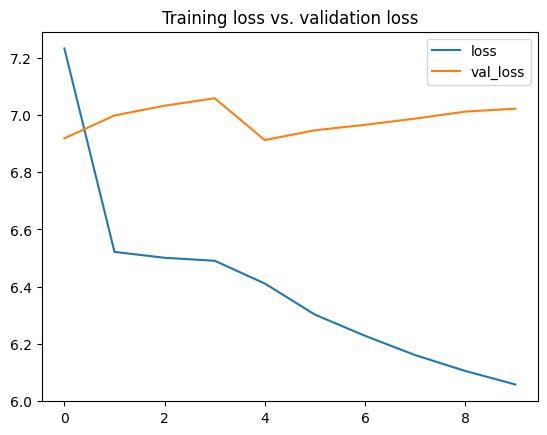

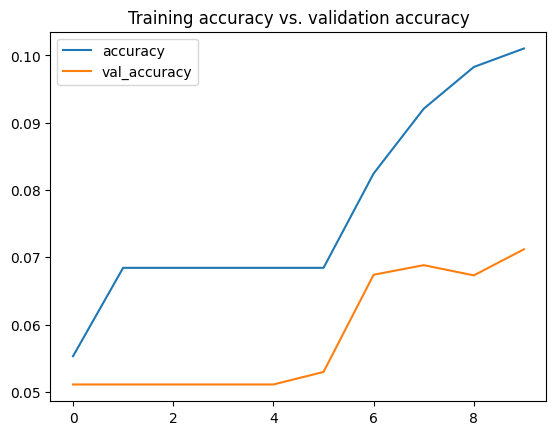

In [12]:
render_history(history)

In [13]:
def decode(indices):
    return " ".join([vocabulary[index] for index in indices if vocabulary[index] is not ""])

import numpy as np

def generate(model, seed_text, generated_sequence_length, temperature):

    seed_text = seed_text.lower()
    for punctuation in ".,:;?!":
        seed_text = seed_text.replace(punctuation, " " + punctuation)

    input_sequence = encoder(seed_text).numpy()

    generated_sequence = list(input_sequence[::])

    # Pad.
    padding = [0] * (sequence_length - len(input_sequence))
    input_sequence = padding + list(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(generated_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0), verbose=False)
        predicted_index = get_index_from_prediction(prediction[0], temperature)
        generated_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(generated_sequence)
    for punctuation in ".,:;?!":
        text = text.replace(" " + punctuation, punctuation)
    print(text)
    print("")

        
def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)
# temperature means how much randomness we want to introduce
# 0 means no randomness
# 1 means full randomness
# 0.5 means some randomness
# argmax returns the index of the highest value in the array      
generate(model, "we are all doomed", 100, temperature=1.0)

<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_7002/1259731961.py:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return " ".join([vocabulary[index] for index in indices if vocabulary[index] is not ""])


we are all doomed watched. looks and, before credit, and loosed them of. and before them a shelf.. jot away. his placed till sot had while their moonlight to was sound. and madness. came [UNK] which question--the with a man. but extended about for.,. it was he [UNK], the professors, the wall, and a trip and prepared previous white silent investigations, the obliterating with house of began at being in without start; else and so a expanse you'll earth's oxford was gaze



tf.Tensor(
[[ 292    8  301  201    2 7131 1056    6    2 1359  383   23   20 1378
     3    9   40 5423    5  877  457   13   34    2 1297    6    2 4769
  1499   20 3856 3736]], shape=(1, 32), dtype=int32)
1/1 [==============================] - 2s 2s/step


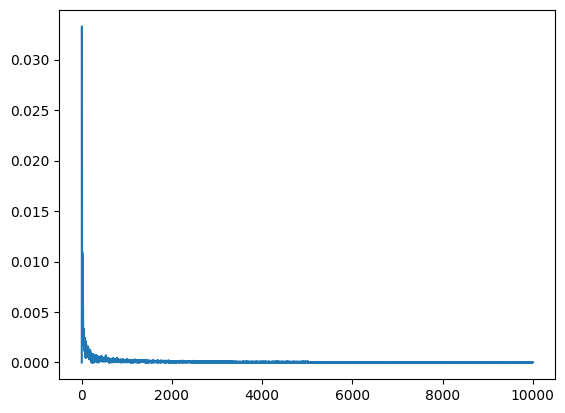

In [15]:


for x, _ in dataset_train.shuffle(1000).batch(1).take(1):
    print(x)
    prediction = model.predict(x)
    plt.plot(prediction[0])